## Stochastic environment (First requirement)

In [182]:
import numpy as np
import matplotlib.pyplot as plt 
import Configuration as config
from scipy import stats
from scipy import optimize
from tqdm.notebook import tqdm

### Stochastic environment 
The stochastic environment takes as "input" the action of the agent which corresponds to the bid. Then it simulates the distribution from which the other bids are sampled and the probability conversion (prob. of buying given a price -> demand curve normalized). Eventually, it outputs the reward associated with  

In [183]:
class pricing_stochastic_env():
    def __init__(self, probability_conversion):
        #self.rewards 
        self.probability_conversion = probability_conversion

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost) * d_t      # the reward is equal to the profit given by (price-cost)*expected demand (sampled)
        return d_t, r_t


    

In [184]:
class bidding_stochastic_env():
    def __init__(self, B, T, lambdas, n_advertisers):
        self.B = B
        self.T = T      
        #self.rho = B/T
        self.lambdas = lambdas
        self.n_slots = len(self.lambdas)
        self.ctrs = np.ones(n_advertisers+1)    # for simplicity we keep them all equal to 1, the +1 is for including myself

    def get_winners(self, bids):
        adv_values = self.ctrs*bids                 # computing values = q*b
        adv_ranking = np.argsort(adv_values)        # array with the index of adv_values sorted in increasing order
        winners = adv_ranking[-self.n_slots:]       # taking the last n_slots indexes, i.e. the indexes of the highest values
        winners_values = adv_values[winners]
        return winners, winners_values
        
    def get_payments_per_click(self, values, winners):
        payments_per_click = np.zeros(self.n_slots)
        for i,w in enumerate(winners):
            Y = sum(np.delete(values, i)*self.lambdas[-self.n_slots+1:])
            X = sum(np.delete(values*self.lambdas, i))
            payments_per_click[i] = (Y-X)/(self.lambdas[i]*self.ctrs[w])
        return payments_per_click.round(2)
        '''adv_ranking = np.argsort(values)    # sorting the values (q param times bid) in increasing order
        for i in range(self.n_slots):
            payment = values[adv_ranking[-i]]/self.ctrs[adv_ranking[-i-1]]  # generalized second price auctions
        return payment.round(2)'''

    def round(self, bids):
        # bids contains all bids, including mine which is stored in the first position
        winners, values = self.get_winners(bids)        # winners are the indexes of the highest values in the array
        payments_per_click = self.get_payments_per_click(values, winners)
        return winners, payments_per_click


### Pricing algorithm
Build a pricing strategy using the continuous set of prices $p \in [0,1]$ and Gaussian Processes

In [185]:
# taken from lab session 3
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

Implementing the Gaussian Processes in our agent:
- recall to normalize the input -> in the continuous set $[0,1]$

In [186]:
# taken from lab session 3 as well
class pricing_agent():
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))      # from PAPER LINKED IGP-UCB ALGORITHM
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        ucbs = self.mu_t + self.beta(self.t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

### Bidding algorithms
Consider a sequence of generalized second-price auctions. Build two learning algorithms to deal with the bidding problem:
- a primal-dual algorithm for truthful auctions
- a UCB-like algorithm

Generalized second-price auctions: each advertiser $a$ pays $p_a = \dfrac{q_{a+1}}{q_a} b_{a+1}$ if the ad is clicked. This has to be 

In [187]:
class primal_dual_agent():
    def __init__(self, B, T, eta) -> None:
        pass
    
    def action():
        # choose price to bid
        pass
    
    def update():
        pass

This can be implemented following the algorithm in the slide 18 from slide package 8.

In [188]:
class UCB_agent():
    def __init__(self, B, T, prices, n_advertisers, n_users, eta=0.1) -> None:
        self.B = B          # budget
        self.T = T          # number of rounds
        self.arms = prices  # arms of the UCB algorithm -> discretization of the prices
        self.eta = eta      # learning rate
        self.N_pulls = np.zeros(len(self.arms))     # number of pulls for each arm
        self.bar_c = np.zeros(len(self.arms))       # empirical average cost for each arm 
        self.bar_f = np.zeros(len(self.arms))       # empirical average utility for each arm
        self.t = 0          # time step
        self.a_t = None     # arm played at time t
        self.n_advertisers = n_advertisers          # number of advertisers (excluded the agent)
        self.rho = B/T      # budget per round
        self.n_users = n_users  
        self.my_valuation = 0.6         # CHOSEN RANDOMLY, CHECK
        
    def action(self):
        # choose price to bid   
        if self.B <= 1:
            print('Budget depleted at round {}',self.t)
            self.a_t = 0        # cannot bid because the budget is depleted
        elif self.t < len(self.arms):     # have not pulled all arms yet
            self.a_t = self.arms[self.t]
        else:
            # arm choosen by UCB algorithm
            bar_f_UCB = self.bar_f + np.sqrt(2*np.log(self.T)/self.N_pulls)     
            bar_c_LCB = self.bar_c - np.sqrt(2*np.log(self.T)/self.N_pulls) 
            
            # to decide which arm to play we need to solve the linear problem first
            win_probabilities = stats.beta.cdf(self.arms, self.n_advertisers, 1)

            c = -(self.my_valuation-self.arms)*win_probabilities
            A_ub = [self.arms*win_probabilities]
            b_ub = [self.rho]
            A_eq = [np.ones(len(self.arms))]
            b_eq = [1]
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
            gamma = res.x
            #print('gamma: {}, type of gamma: {}', gamma, type(gamma))
            expected_clairvoyant_utilities = np.array([-res.fun for u in range(self.n_users)])     # res.fun is the optimal value of the LP problem
            expected_clairvoyant_bids = np.array([sum(self.arms*gamma*win_probabilities) for u in range(self.n_users)])

            #self.a_t = self.arms[np.argmax(expected_clairvoyant_utilities - expected_clairvoyant_bids)]     # copilot, not sure about this line!
            self.a_t = self.arms[np.argmax(expected_clairvoyant_utilities)]     # copilot, not sure about this line!
        return self.a_t
    
    def update(self, f,c):
        arm_played_index = np.where(self.arms==self.a_t)[0][0]      # bad code to get the index of an element, no index() bc it is a numpy array
        self.N_pulls[arm_played_index] += 1    # we update the number of pulls for the arm played

        # if you are wondering why is there a minus sign in the mean update -> check out this https://math.stackexchange.com/questions/106700/incremental-averaging
        self.bar_c[arm_played_index] += (c - self.bar_c[arm_played_index])/self.N_pulls[arm_played_index]    # update the empirical average cost
        self.bar_f[arm_played_index] += (f - self.bar_f[arm_played_index])/self.N_pulls[arm_played_index]    # update the empirical average cost
        self.t += 1     # incresing time step
        self.B -= c     # updating the budget

### General framework to be modeled
Recall that:
- GPUCB1 works on the continuous domain [0,1]
- the UCB-like algorithm for bidding works on the discretized set of bids

In [189]:
# importing parameters
ITERATIONS = config.ITERATIONS
AUCTIONS = config.AUCTIONS
N_USERS = config.N_USERS
N_ADVERTISERS = config.N_ADVERTISERS    # number of companies that compete for slot auctions, including myself
NUMBER_OF_ARMS = config.NUMBER_OF_ARMS    # needed for the UCB algorithm
PRICES = config.PRICES    # actual arms of the ucb algorithm
BUGDET = config.BUGDET
NUMBER_OF_SLOTS = config.NUMBER_OF_SLOTS
LAMBDAS = config.LAMBDAS


conversion_probability = lambda p: 1-p/20
pricing_agent = pricing_agent(ITERATIONS, 100)
bidding_agent = UCB_agent(BUGDET, ITERATIONS, PRICES, N_ADVERTISERS,N_USERS)


pse = pricing_stochastic_env(conversion_probability)
bse = bidding_stochastic_env(B=BUGDET, T=ITERATIONS, lambdas=LAMBDAS, n_advertisers=N_ADVERTISERS)

my_valuation = 0.8      # randomly chosen
utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0


for round in tqdm(range(ITERATIONS)):
    p_t = pricing_agent.pull_arm()    # pricing agent choose a price p for the product

    for auction in range(AUCTIONS):
        my_bid = bidding_agent.action()    # bidding agent decides how much to bid 
        other_bids = np.random.uniform(0, 1, size = (N_ADVERTISERS)) # size = (N_ADVERTISERS, N_USERS) 
        all_bids = np.append(my_bid, other_bids)    # all bids, including mine in first position
        winners, payments_per_click = bse.round(bids=all_bids)    # somebody wins the auction
        m_t = other_bids.max()    # maximum bid among the other advertisers
        my_win = 0 if 0 in winners else 1 
        f_t, c_t = (my_valuation-m_t)*my_win, m_t*my_win
        bidding_agent.update(f_t, c_t)
        # logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        total_wins+=my_win
        

  0%|          | 0/100 [00:00<?, ?it/s]

Budget depleted at round {} 196
Budget depleted at round {} 197
Budget depleted at round {} 198
Budget depleted at round {} 199
Budget depleted at round {} 200
Budget depleted at round {} 201
Budget depleted at round {} 202
Budget depleted at round {} 203
Budget depleted at round {} 204
Budget depleted at round {} 205
Budget depleted at round {} 206
Budget depleted at round {} 207
Budget depleted at round {} 208
Budget depleted at round {} 209
Budget depleted at round {} 210
Budget depleted at round {} 211
Budget depleted at round {} 212
Budget depleted at round {} 213
Budget depleted at round {} 214
Budget depleted at round {} 215
Budget depleted at round {} 216
Budget depleted at round {} 217
Budget depleted at round {} 218
Budget depleted at round {} 219
Budget depleted at round {} 220
Budget depleted at round {} 221
Budget depleted at round {} 222
Budget depleted at round {} 223
Budget depleted at round {} 224
Budget depleted at round {} 225
Budget depleted at round {} 226
Budget d

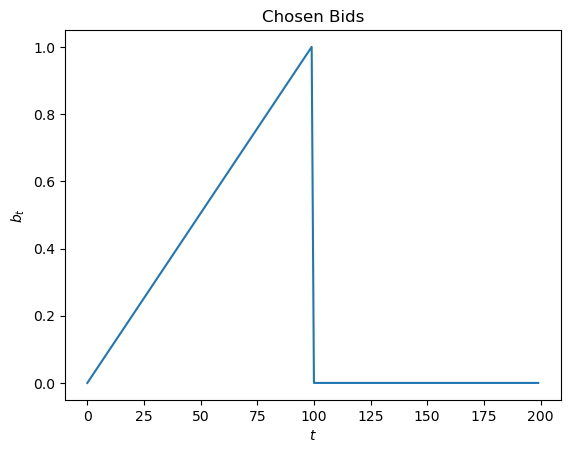

In [191]:
plt.plot(my_bids[:200])
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()